#### Import packages

In [1]:
import gudhi as gd
import networkx as nx
import csv
import numpy as np
from numpy import random
import itertools
import time
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gamma
import subprocess
import os
import math
import multiprocessing as mp
import pandas as pd

%matplotlib inline

In [2]:
## a code snippet to store the local path of the folder in which the current file is stored
# cmd = subprocess.Popen('pwd', stdout=subprocess.PIPE)
# cmd_out, cmd_err = cmd.communicate()
# local_path = os.fsdecode(cmd_out).strip()

#### Import vascular network data. 
Change '2020' to load other datasets (options available are '2019' and '2018')

In [2]:
mouse_brain_vasc_network = pd.read_pickle('../data/annotated_mouse_brain_vasc_network_2020.pkl')

## Grouping the networks by their annotations according Allen Atlas notation
regional_groups = mouse_brain_vasc_network.groupby(by=['RL1','RL2'])

In [5]:
rl1 = mouse_brain_vasc_network.RL1.unique()
rl2 = mouse_brain_vasc_network.RL2.unique()

## Total number of region labels
print((len(rl1),len(rl2)))

(1339, 1339)


#### Import labels that fall under labels: 640 (BS) and 3 (CH).
The above labels are chosen for experimentation with Topological data analysis (Persistent Homology) and Mahcine learning due to the limitations in the number of samples 

In [7]:
with open('../data/ML_2020/region_2020_640_labels.txt','r') as f:
    lines = f.readlines()
labels_640 = [[float(y) for y in line.strip().split(' ')] for line in lines]

with open('../data/ML_2020/region_2020_3_labels.txt','r') as f:
    lines = f.readlines()
labels_3 = [[float(y) for y in line.strip().split(' ')] for line in lines]

Consider networks that have number of nodes between 500 to 1500. This choice is a little arbitrary except that we need network samples that are approximately atleast as big as 500 nodes but that are not too big.

In [8]:
sizes = {}
for label in labels_640:
    region = regional_groups.get_group((label[0],label[1]))
    n = len(region)
    if (n>=500) and (n<= 1500):
        df = region.fillna(region.dt.describe()['50%'])
        sizes[(label[0],label[1])] = (640,n,np.mean(1/df.dt))
        
for label in labels_3:
    region = regional_groups.get_group((label[0],label[1]))
    n = len(region)
    if (n>=500) and (n<= 1500):
        df = region.fillna(region.dt.describe()['50%'])
        sizes[(label[0],label[1])] = (3,n,np.mean(1/df.dt))

Take a look at a network sample from each region

In [9]:
region1 = regional_groups.get_group(list(sizes.keys())[0])
region2 = regional_groups.get_group(list(sizes.keys())[-1])

In [10]:
region1.head(5)

,V1,RL1,VX1,VY1,VZ1,V2,RL2,VX2,VY2,VZ2,length,dt
5935852,3890273.0,-945.0,3873.0,6662.0,14294.0,3894667.0,-945.0,3910.0,6653.0,14311.0,47.36525,2.112252
5944372,3895679.0,-945.0,3899.0,6704.0,14315.0,3902134.0,-945.0,3881.0,6660.0,14338.0,58.44930,5.796136
5947867,3898565.0,-945.0,3795.0,6645.0,14324.0,3924693.0,-945.0,3866.0,6588.0,14431.0,195.15290,2.289787
5948853,3898565.0,-945.0,3795.0,6645.0,14324.0,3922716.0,-945.0,3779.0,6683.0,14423.0,190.66700,2.057760
5953367,3901605.0,-945.0,3824.0,6585.0,14336.0,3907563.0,-945.0,3826.0,6556.0,14360.0,43.23239,2.079232


In [32]:
region2.head(5)

,V1,RL1,VX1,VY1,VZ1,V2,RL2,VX2,VY2,VZ2,length,dt
4364591,2858123.0,510.0,5760.0,1572.0,11127.0,2868771.0,510.0,5739.0,1650.0,11159.0,121.11060,1.992310
4369923,2861325.0,510.0,5885.0,1801.0,11138.0,2863819.0,510.0,5865.0,1811.0,11144.0,23.14543,2.138414
4369951,2860979.0,510.0,6121.0,2339.0,11136.0,2863840.0,510.0,6112.0,2323.0,11144.0,19.80862,1.915143
4370560,2861367.0,510.0,6070.0,2735.0,11136.0,2880354.0,510.0,6171.0,2710.0,11193.0,178.65530,2.131732
4371033,2861325.0,510.0,5885.0,1801.0,11138.0,2879567.0,510.0,5943.0,1823.0,11191.0,91.80286,2.204412


#### Helper functions

Extract cubical regions of length, breadth and width of 500 micrometers. Systematic sampling using box-like non-overlapping regions. 

In [22]:
def extract_region(lb,delta,ax):
    d = {'X':['VX1','VX2'],'Y':['VY1','VY2'],'Z':['VZ1','VZ2']}     
    indices1 = list(region[(region[d[ax][0]] <= lb+delta) \
                                         & (region[d[ax][0]] >= lb)].index)
    indices2 = list(region[(region[d[ax][1]] <= lb+delta) \
                                         & (region[d[ax][1]] >= lb)].index)
    if indices1 and indices2:
        return np.intersect1d(np.array(indices1),np.array(indices2)).flatten()
    else:
        return np.array([])

Extract indices of the edges/connections that make up vascular networks in the cubical regions specified by the function extract_region(lb,delta,ax)

In [24]:
def extractgraph_indices(initx,initz):
    indicesx = extract_region(initx,500,'X')
    indicesz = extract_region(initz,500,'Z')
    if (indicesx.size>0) and (indicesz.size>0):
        print(f'non-empty-{0}')
        indices = np.intersect1d(indicesx,indicesz).flatten()
        indicesy = extract_region(inity,500,'Y')
        if (indices.size > 0) and (indicesy.size > 0):
            print(f'non-empty-{1}')
            indices = np.intersect1d(indices,indicesy).flatten()
            if indices.size > 0:
                print(f'non-empty-{2}')
                G = nx.Graph()
                for k in indices:
                    G.add_edge(region['V1'][k], region['V2'][k],\
                               dt = region['dt'][k],\
                               length = region['length'][k])

                return [H, initx, inity, initz, 500, len(H.nodes()), len(H.edges())]
            else:
                return None
        else:
            return None

The original networks have multi-edges. In the main funuction whenever such multi-edges are found, we call the following function through which the parallel combination is turned into a single edge/connection with an 
effective resistance corresponding to that combination. Then using this effective resistance and the length of the vessel segment the effective thickness of the vessel segment is computed.  

In [16]:
from scipy.stats import hmean 

def eff_radius(weights,combination):
    resistances = [l/r**2 for r,l in weights]
    if combination == 'parallel':
        eff_resistance = hmean(resistances)/len(resistances)
        eff_length = np.mean([l for r,l in weights])
    else:
        eff_resistance = sum(resistances)
        eff_length = sum([l for r,l in weights])
    return math.sqrt(eff_length/eff_resistance)

In [26]:
"""
Compute an undirected weighted graph with reciprocal (or not) of effective radii/thicknesses of vessels
as the weights. 
The boolean argument 'descending' specifies whether the radii or the resistances of the
vessels are considered. 
The boolean argument 'reweigh' specifies whether or not to perform quantile normalization
of the underlying distribution of weights (gamma distribution is used as the reference distribution)
The boolean argument 'not_shuffled' specifies whether or not to shuffle and reassign the edge weights
"""

def graph(data,descending=True,reweigh=True,not_shuffled=True):
    G = nx.MultiGraph()
    for k in range(len(data)):
        G.add_edge(int(data['V1'].iloc[k]), int(data['V2'].iloc[k]),\
                       dt = data['dt'].iloc[k], length = data['length'].iloc[k])
    
    edge_list = {}
    for edge in list(G.edges.data()):
        e = (edge[0],edge[1])
        if e in edge_list:
            edge_list[e].append((edge[2]['dt'],edge[2]['length']))
        else:
            edge_list[e] = [(edge[2]['dt'],edge[2]['length'])]
     
    x = []
    if descending:
        for edge in edge_list:
            if len(edge_list[(edge[0],edge[1])]) == 1:
                x.append(1/edge_list[(edge[0],edge[1])][0][0])
            else:
                x.append(1/eff_radius(edge_list[(edge[0],edge[1])],'parallel'))
    else:
        for edge in edge_list:
            if len(edge_list[(edge[0],edge[1])]) == 1:
                x.append(edge_list[(edge[0],edge[1])][0][0])
            else:
                x.append(eff_radius(edge_list[(edge[0],edge[1])],'parallel'))
    if reweigh:
        x = get_new_weights(x)
        
    if not not_shuffled:
        y = x.copy()
        np.random.shuffle(x)
        if x == y:
            print(f'number of nodes: {len(x)}')
    
    H = nx.Graph()           
    for k,edge in enumerate(edge_list):
        H.add_edge(edge[0], edge[1], weight = x[k])
        
    return nx.convert_node_labels_to_integers(H,first_label=0)

Visualizing distribution of radii/thicknesses of vessel segments of a network sample

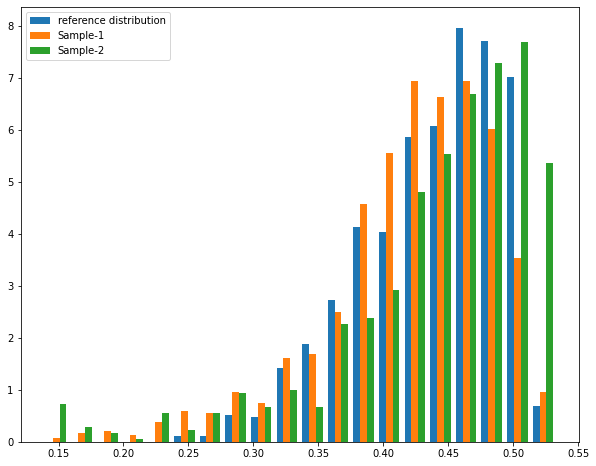

In [13]:
## Before re-weighing
size_reference_dist = round(np.mean([sizes[key][1] for key,val in sizes.items()]))
mu = np.mean([sizes[key][2] for key,val in sizes.items()])
reference_dist = [1/x for x in gamma.rvs(a=1.3,loc=mu+1.5,scale=0.3,size=size_reference_dist)]
plt.figure(figsize=(10,8))
plt.hist([reference_dist,np.array([1/x for x in region1.fillna(region1.dt.describe()['50%']).dt]),\
          np.array([1/x for x in region2.fillna(region2.dt.describe()['50%']).dt])],
         bins = 20,
         density=True,
         label=['reference distribution','Sample-1','Sample-2'])
plt.legend(loc='upper left')
plt.show()

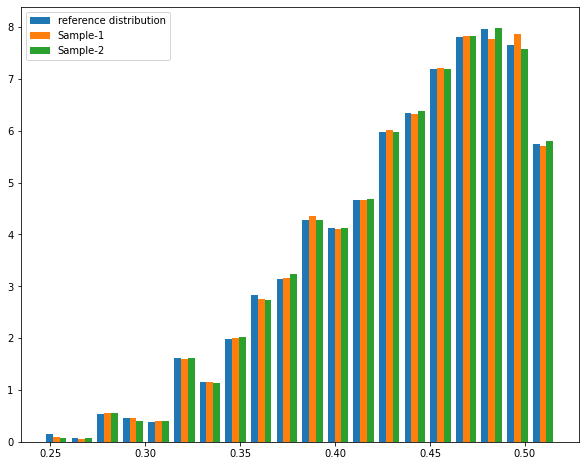

In [15]:
weights = {}
k = 0
for region in [region1,region2]:
    temp = [1/x for x in region.fillna(region.dt.describe()['50%']).dt]
    weights[k] = [np.percentile(reference_dist,stats.percentileofscore(temp,x)) for x in temp]
    k += 1

## After re-weighing
plt.figure(figsize=(10,8))
plt.hist([reference_dist,weights[0],weights[1]],
         bins = 20,
         density=True,
         label=['reference distribution','Sample-1','Sample-2'])
plt.legend(loc='upper left')
plt.show()

Quantile normalization using a gamma distribution as the reference distribution.
Since we're interested in a quantity that is inversely proportional to the radii (as weights of the graph), notice that the reciprocal of the values of the gamma random variable are taken --  the values of the radii/thickness roughly follow gamma-like distributions (heavy tailed towards right: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html). This choice is arbitrary and any distribution that is close to the actual distribution of radii/thicknesses can be used (closer to the actual ditribution the better)

In [11]:
"""
weights: a list or an array of positive real numbers equal to reciprocal of the 
thicknesses of the vessel segments.
a, offset and scale equal to the chosen parameters of the gamma ditribution.
"""

def get_new_weights(weights,a=1.3,offset=1.5,scale=0.3):
    reference_dist = [1/x for x in gamma.rvs(a=a,loc=mu+offset,scale=scale,size=size_reference_dist)]
    
    return [np.percentile(reference_dist,stats.percentileofscore(weights,x)) for x in weights]

Contruct a simplex tree (1D simplex) from the structure (edges/connections) and weights of the 
graph/network. The filtration function is simply the edge weights for the edges and minimum of
edge weights for the nodes that are incident on a set of edges. Here's the link to the documentation page: https://gudhi.inria.fr/python/latest/simplex_tree_ref.html, and the link to wiki page for simplicial complex: https://en.wikipedia.org/wiki/Simplicial_complex. 

In [27]:
def create_simplicial_complex(g):
    st = gd.SimplexTree()
    for edge in list(g.edges.data()):
        st.insert([edge[0],edge[1]],filtration=edge[2]['weight'])
        
    return st

Compute persistence diagrams of the network samples from the vasculature dataset (with or without normalized and with or without randomly shuffled weight distributions). Here's the link to a tutorial on computing persistence homology using GUDHI with some examples: https://github.com/GUDHI/TDA-tutorial  

In [29]:
# for label in sizes:
#     region = pd.DataFrame(regional_groups.get_group((label[0],label[1])))
#     df = region.fillna(region.dt.describe()['50%'])
#     print(label)
#     H = graph(df[['V1','V2','dt','length']])
#     ph = create_simplicial_complex(H).persistence()
#     with open(local_path + '/data/annotated_PH_2020/reweighed_PH_'+str(sizes[label][0])+\
#               '_csv/ph_'+str(sizes[label][0])+'_'+str(int(label[0]))+'_'+str(int(label[1]))\
#               +'.csv', 'w+') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow([len(H.nodes()),len(H.edges())])
#         for row in ph:
#             writer.writerow(list(row[1]))

Sample networks and store the data. The following is an optional cell if the graphs/networks themselves are reqiured. 

In [ ]:
# M = np.median(np.arange(miny,maxy,500))
# for k in np.arange(500,M,500):
#     inity = np.median(np.arange(miny,maxy,500))-k
#     print(inity)
#     pool = mp.Pool(12)
#     results = [pool.apply_async(extractgraph_cylindricalregions, args=item) for item in list(itertools.product(np.arange(minx,maxx,500),np.arange(minz,maxz,500)))]
#     pool.close()
#     pool.join()
    
#     output = [p.get() for p in results]
#     not_none = [item for item in output if item != None]
#     with open(f'/home1/sgmark/networks/TDA-VN-brain/data/annotated_box_graph_data_2020_500/network_data_box_sampling_nooverlaps_m_500_{int(k)}'+'.csv','a')\
#     as fh:
#         writer = csv.writer(fh)
#         for g in not_none:
#             writer.writerow([0,0,0,0,0,0])
#             writer.writerow([g[1],g[2],g[3],g[4],g[5],g[6]])
#             for t in list(g[0].edges.data()):
#                 writer.writerow([t[0],t[1],t[2]['weight']])